In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create a data frame to store the dataset and use number to represent a class
def initImg(root, matrix_label):
    label_lst = []
    class_lst = []
    img_lst = []
    label = 0
    for file in os.listdir(root):
        class_path = os.path.join(root, file)
        for fn in os.listdir(class_path):
            img_path = os.path.join(class_path, fn)
            img_lst.append(img_path)
            class_lst.append(file)
            if file not in matrix_label:
                matrix_label.append(file)
            label_lst.append(label)
        label += 1

    return pd.DataFrame({
        "filename": img_lst,
        "class": class_lst,
        "label": label_lst
    })

In [7]:
def preprocessImg(img):
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    sharpened = cv2.addWeighted(img, 1, laplacian, 1.0, 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(sharpened)
    return clahe_img

#two essential functions for extracting features
def build_bow_histogram(descriptors, kmeans, n_clusters):
    if descriptors is None:
        return np.zeros(n_clusters)

    descriptors = np.asarray(descriptors, dtype=np.float32)
    words = kmeans.predict(descriptors)

    histogram, _ = np.histogram(words, bins=np.arange(n_clusters + 1))

    return histogram

def get_descriptors(img_path, preprocess=True):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if preprocess:
        gray = preprocessImg(gray)

    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(gray, None)

    return descriptors

def descriptorlst(train_df):
    descriptor_lst = []

    for _, row in train_df.iterrows():
        descriptors = get_descriptors(row['filename'], preprocess=True)
        if descriptors is not None:
            descriptor_lst.extend(descriptors)
    descriptor_lst = np.asarray(descriptor_lst, dtype=np.float32)

    return descriptor_lst

In [8]:
root_dir = 'Aerial_Landscapes'
matrix_lst = []
df = initImg(root_dir, matrix_lst)

In [9]:
# classifier: knn or sgd method
def dataloader():
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df['label']
    )
    descriptor_lst = descriptorlst(train_df)
    kmeans = MiniBatchKMeans(n_clusters=100, random_state=42)
    kmeans.fit(descriptor_lst)
    data_type = ['train_df', 'test_df']
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for ele in data_type:
        if ele == 'train_df':
            data = train_df
        elif ele == 'test_df':
            data = test_df

        for _, row in data.iterrows():
            descriptors = get_descriptors(row['filename'], preprocess=False)
            hist = build_bow_histogram(descriptors, kmeans, 100)
            if ele == 'train_df':
                X_train.append(hist)
                y_train.append(row['label'])
            else:
                X_test.append(hist)
                y_test.append(row['label'])

    return X_train, y_train, X_test, y_test

c:\Users\LeeX0\.conda\envs\COMP9517\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\LeeX0\.conda\envs\COMP9517\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


training complete
Accuracy: 57.92%
Precision: 0.58
Recall: 0.58
F1-Score: 0.57
              precision    recall  f1-score   support

           0       0.51      0.70      0.59       160
           1       0.40      0.47      0.43       160
           2       0.58      0.53      0.55       160
           3       0.58      0.74      0.65       160
           4       0.42      0.51      0.46       160
           5       0.82      0.81      0.82       160
           6       0.53      0.64      0.58       160
           7       0.57      0.44      0.49       160
           8       0.35      0.24      0.28       160
           9       0.64      0.68      0.66       160
          10       0.96      0.67      0.79       160
          11       0.75      0.54      0.63       160
          12       0.63      0.67      0.65       160
          13       0.67      0.83      0.74       160
          14       0.34      0.23      0.27       160

    accuracy                           0.58      2400
 

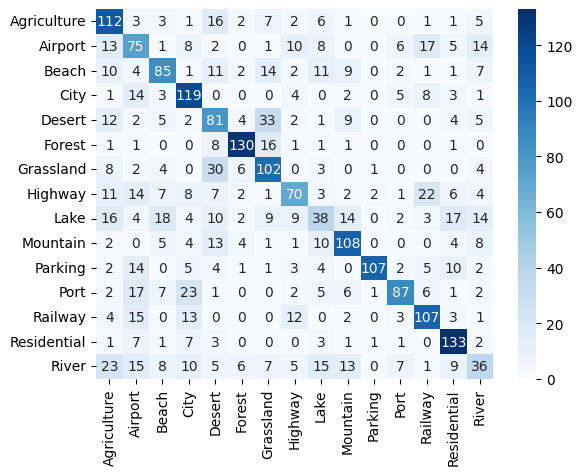

Test Accuracy: 0.5791666666666667


In [10]:
X_train, y_train, X_test, y_test = dataloader()

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("training complete")

# Predict and evaluate
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=matrix_lst, yticklabels=matrix_lst)
plt.show()
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Training complete !
Accuracy: 62.38%
Precision: 0.62
Recall: 0.62
F1-Score: 0.62
              precision    recall  f1-score   support

           0       0.58      0.61      0.60       160
           1       0.54      0.48      0.51       160
           2       0.67      0.59      0.63       160
           3       0.70      0.65      0.67       160
           4       0.46      0.58      0.51       160
           5       0.84      0.74      0.79       160
           6       0.48      0.64      0.55       160
           7       0.58      0.59      0.58       160
           8       0.36      0.27      0.31       160
           9       0.75      0.73      0.74       160
          10       0.87      0.91      0.89       160
          11       0.70      0.66      0.68       160
          12       0.68      0.69      0.69       160
          13       0.72      0.84      0.78       160
          14       0.43      0.38      0.40       160

    accuracy                           0.62      2400

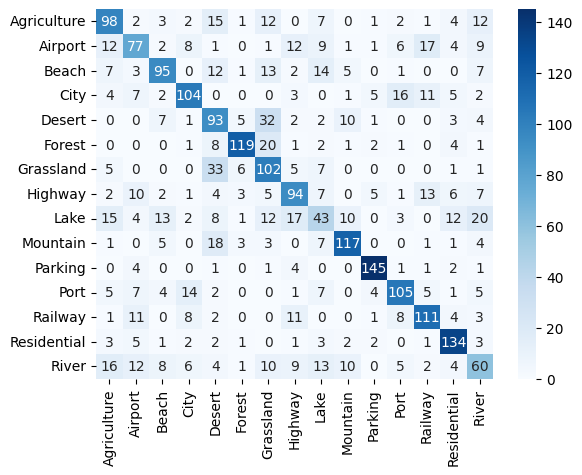

Test Accuracy: 0.62375


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(solver='lbfgs', max_iter=500)
clf.fit(X_train_scaled, y_train)
print("Training complete !")

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=matrix_lst, yticklabels=matrix_lst)
plt.show()
print("Test Accuracy:", accuracy_score(y_test, y_pred))
